In [1]:
import pandas as pd
from COMETH import Skeleton,DynamicSkeleton
import nimblephysics as nimble
import numpy as np
import json
import time
import csv

gui = nimble.NimbleGUI()
gui.serve(8080)
# sudo lsof -iTCP:8080 -sTCP:LISTEN

s12 = Skeleton('BODY12.xml')
# Rajagopal
# s = DynamicSkeleton('/home/rmhri/markerless-human-perception/src/hpe/src/Biomechanical-Model/BODY15_constrained_3D.xml')
# BSM
s = DynamicSkeleton(config='BODY15_constrained_3D.xml', \
    # osim_file='/media/rmhri/mrom/data/skel_models_v1.1/bsm.osim',\
    # max_velocity=10
    )

s.qdot_l *= 2
s.qdot_u *= 2

GUIWebsocketServer will start serving a WebSocket server on ws://localhost:8070
Web GUI serving on http://localhost:8080
Setting len to 0.1
Setting neutral pos to   0
0.7
  0
Setting len to 0.3
Setting neutral pos to    0
-0.6
   0
Setting len to 0.1
Setting neutral pos to   0
0.2
  0


/home/emartini/multiview_hpe_aggregator/COMETH/COMETH/DynamicSkeleton.py:205: RuntimeWarning: invalid value encountered in add
  s_avg = (self.q_l + self.q_u) / 2


127.0.0.1 - - [28/May/2024 19:42:49] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [28/May/2024 19:42:49] "GET /bundle.js HTTP/1.1" 200 -


In [2]:
# Read the file in Shafagh format and collapse the header into one line

# filename = "tmp/L266/23-10-28_Shafagh_free_world.csv"
# filename = "tmp/L266/23-10-28_Shafagh_free.csv"
filename = "/home/emartini/nas/MAEVE/dataset/L266/23.10.28/23-10-28_Shafagh_free_world.csv"
out_header = ['']*465
out_file = []
with open(filename, newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    for i,row in enumerate(spamreader):
        if i > 1 and i < 7 and i != 4:
            for j in range(465):
                if row[j] == "''" or out_header[j] == '':
                    out_header[j] += row[j]
                else:
                    out_header[j] += "." + row[j]
        if i > 6:
            out_file.append(row)

with open(filename.replace(".csv",".oneheader.csv"), 'w') as f:
    writer = csv.writer(f,delimiter=',')
    writer.writerow(out_header)
    writer.writerows(out_file)


In [3]:
# Read the modified version of the csv in pandas
df = pd.read_csv(filename.replace(".csv",".oneheader.csv"),delimiter=',')

# header = list(df.columns)

# bones = []

# for h in range(df.shape[1]):
#     if "Bone.Skeleton:" in header[h] and "Position" in header[h]:
#         bones.append(header[h].split('.')[1].split(":")[1])
# print(list(set(bones)))        
        
# ['RThumb2', 'LPinky1', 'LMiddle2', 'LIndex2', 'RIndex2', 'RMiddle1', \
#     'LPinky3', 'RPinky1', 'RPinky3', 'RMiddle3', 'Neck', 'RRing3', 'LMiddle1', \
#         'RShoulder', 'LHand', 'RIndex1', 'LIndex1', 'LIndex3', 'LFArm', 'RHand', \
#             'LShoulder', 'LRing1', 'LRing3', 'RThumb1', 'RThumb3', 'Ab', 'LUArm', \
#                 'RIndex3', 'RPinky2', 'Skeleton', 'LThumb1', 'LThumb3', 'LPinky2', \
#                     'Head', 'RMiddle2', 'LRing2', 'RRing2', 'RRing1', 'RFArm', 'LThumb2', \
#                         'RUArm', 'Chest', 'LMiddle3']

s.body_dict["thorax"] = "LClavicle"

kps_optitrack = ['LHand','LFArm','RHand','LUArm','RFArm','RUArm']
kps =  ['', 'LHand', 'RHip', 'RUArm',  'LFArm', 'LHip', 'RFArm', 'RHand', '', 'LUArm', '', '']
Q = []
P = []
P_target = []
times = []
s.prob = None
s.reset()
for t in range(0,df.shape[0]):
    target = []
    #np.array([np.array(df.loc[t,["Bone.Skeleton:"+l+".Position.X","Bone.Skeleton:"+l+".Position.Y","Bone.Skeleton:"+l+".Position.Z"]].to_numpy()) for l in kps]).squeeze()/1000
    for kp in kps:
        if kp == '':
            target.append([np.nan,np.nan,np.nan])
        elif kp == 'LHip':
            LASI = np.array(df.loc[t,["Marker.Skeleton:LASI.Position.X","Marker.Skeleton:LASI.Position.Y","Marker.Skeleton:LASI.Position.Z"]].to_numpy()).squeeze()/1000
            LPSI = np.array(df.loc[t,["Marker.Skeleton:LPSI.Position.X","Marker.Skeleton:LPSI.Position.Y","Marker.Skeleton:LPSI.Position.Z"]].to_numpy()).squeeze()/1000
            target.append((LASI+LPSI) / 2)        
        elif kp == 'RHip':
            RASI = np.array(df.loc[t,["Marker.Skeleton:RASI.Position.X","Marker.Skeleton:RASI.Position.Y","Marker.Skeleton:RASI.Position.Z"]].to_numpy()).squeeze()/1000
            RPSI = np.array(df.loc[t,["Marker.Skeleton:RPSI.Position.X","Marker.Skeleton:RPSI.Position.Y","Marker.Skeleton:RPSI.Position.Z"]].to_numpy()).squeeze()/1000
            target.append((RASI+RPSI) / 2)        
            
        else:
            target.append(np.array(df.loc[t,["Bone.Skeleton:"+kp+".Position.X","Bone.Skeleton:"+kp+".Position.Y","Bone.Skeleton:"+kp+".Position.Z"]].to_numpy()).squeeze()/1000)
    
    target = np.array(target)
    
    # res = np.dot(R,target.reshape(-1,3).transpose()*1000) + T
    Rx = np.array([
        [1,0,0],
        [0,0,1],
        [0,-1,0]
    ])
    res = np.dot(Rx,target.reshape(-1,3).transpose()*1000)
    target = res.transpose()/1000
    
    # print(s.kps)
        
    s12.load_from_numpy(target.reshape(-1,3),s.kps)
    s.load_from_BODY12(s12)
    
    
    
    # s.estimate_confidence()
    if t == 0:
        s.exact_scale()

    else:
        s.exact_scale(max_iterations=10)    

    # s.qpIK(1000,0.01)
    
    gui.nativeAPI().renderSkeleton(s._nimble)
    
    pos = s._nimble.getJointWorldPositions(s.joints)
    pos = s.correct(pos)

    target = target.reshape(-1,1)
    for i in range(0,int(target.shape[0]/3)):
        gui.nativeAPI().createSphere(key=kps[i], radii=np.array([0.01,0.01,0.01]),pos=target[3*i:3*i+3],color=np.array([0,255,0,0.8]))
    
    for i in range(0,int(pos.shape[0]/3)):
        gui.nativeAPI().createSphere(key=s.joints[i].getName(), radii=np.array([0.01,0.01,0.01]),pos=pos[3*i:3*i+3],color=np.array([0,0,0,1]))
    Q.append(s._nimble.getPositions())
    P.append(s.to_numpy())
    P_target.append(target)
    s.reset_history()
    # break
    time.sleep(0.01)
    # break
Q = np.array(Q)
P = np.array(P)
P_target = np.array(P_target)
# print(np.mean(times))

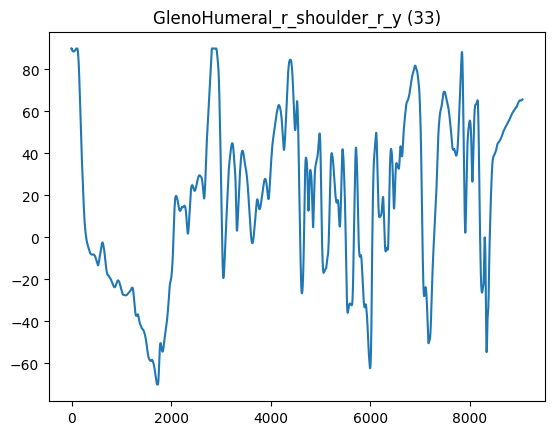

In [4]:

import matplotlib.pyplot as plt
angles = []
for i in range(s._nimble.getNumJoints()):
    j = s._nimble.getJoint(i)
    for k in range(j.getNumDofs()):
        angles.append(j.getName()+'_'+j.getDofName(k))

i = 33
plt.title(angles[i]+" ("+str(i)+")" )
plt.plot(np.array(Q)[:,i]*180/np.pi)
# plt.plot(np.array(Q_qp10r)[:,i]*180/np.pi,label="g25 and +-10 rad/s")
# plt.plot(np.array(Q_qp2r)[:,i]*180/np.pi,label="g25 and +-2 rad/s")
# plt.legend()
plt.show()

In [11]:
import pandas as pd

header = [
"pelvis_tilt",
"pelvis_list",
"pelvis_rotation",
"pelvis_translation_x",
"pelvis_translation_y",
"pelvis_translation_z",
'hip_r_flexion_r',
'hip_r_adduction_r',
'hip_r_rotation_r',
'knee_r_flexion',
'ankle_r_flexion',
'subtalar_r',
'mtp_r',
'hip_l_flexion_l',
'hip_l_adduction_l',
'hip_l_rotation_l',
'knee_l_flexion',
'ankle_l_flexion',
'subtalar_l',
'mtp_l',
'lumbar_bending',
'lumbar_extension',
'lumbar_twist',
'thorax_bending',
'thorax_extension',
'thorax_twist',
'neck_bending',
'neck_extension',
'neck_twist',
'scapula_r_abduction',
'scapula_r_elevation',
'scapula_r_upward_rot',
'shoulder_r_adduction',
'shoulder_r_rotation',
'shoulder_r_flexion',
'elbow_r_flexion',
'radioulnar_r_pro_sup',
'wrist_r_flexion',
'wrist_r_deviation',
'scapula_l_abduction',
'scapula_l_elevation',
'scapula_l_upward_rot',
'shoulder_l_adduction',
'shoulder_l_rotation',
'shoulder_l_flexion',
'elbow_l_flexion',
'radioulnar_l_pro_sup',
'wrist_l_flexion',
'wrist_l_deviation',]

ANGLES = np.array(Q)

ANGLES[:,0:3] = ANGLES[:,0:3]*180/np.pi
ANGLES[:,6:] = ANGLES[:,6:]*180/np.pi

df = pd.DataFrame(data=np.array(Q),columns=header)

df.to_csv(filename.replace(".csv",".angles_COMETH.csv"))